## Load Data

In [1]:
import glob
import torch
import numpy as np
import warnings
from pathlib import Path
warnings.simplefilter("ignore")

/private/home/theop123/miniconda3/envs/habitat-challenge/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obs_paths = glob.glob("demo_data/obs_*.npy")
pose_delta_paths = glob.glob("demo_data/pose_delta_*.npy")
device = torch.device("cuda:0")

obs = np.stack([np.load(obs_path) for obs_path in obs_paths])

pose_delta = np.stack([np.load(pose_delta_path) 
                       for pose_delta_path in pose_delta_paths])

## LSeg Inference Usage

In [3]:
import matplotlib.pyplot as plt

rgb = np.transpose(obs[[2, 5, 20, 50], :3, :, :], (0, 2, 3, 1))
rgb.shape

(4, 480, 640, 3)

In [20]:
# Load pre-trained model
# Download LSeg checkpoint by following README instructions in lseg folder

from home_robot.agent.perception.detection.lseg import load_lseg_for_inference

checkpoint_path = (
    Path().resolve().parent.parent.parent / 
    "perception/detection/lseg/checkpoints/demo_e200.ckpt"
)
device = torch.device("cuda:0")
model = load_lseg_for_inference(checkpoint_path, device)

In [21]:
# Encode pixels to CLIP features

pixel_features = model.encode(rgb)
pixel_features.shape

torch.Size([4, 512, 480, 640])

In [22]:
# Decode pixel CLIP features to text labels - we can introduce new labels
# at inference time

labels = ["tree", "chair", "clock", "couch", "cushion", "lamp", "cabinet", "other"]
one_hot_predictions, visualizations = model.decode(pixel_features, labels)
print(one_hot_predictions.shape, visualizations.shape)

torch.Size([4, 480, 640, 8]) (4, 480, 640, 3)


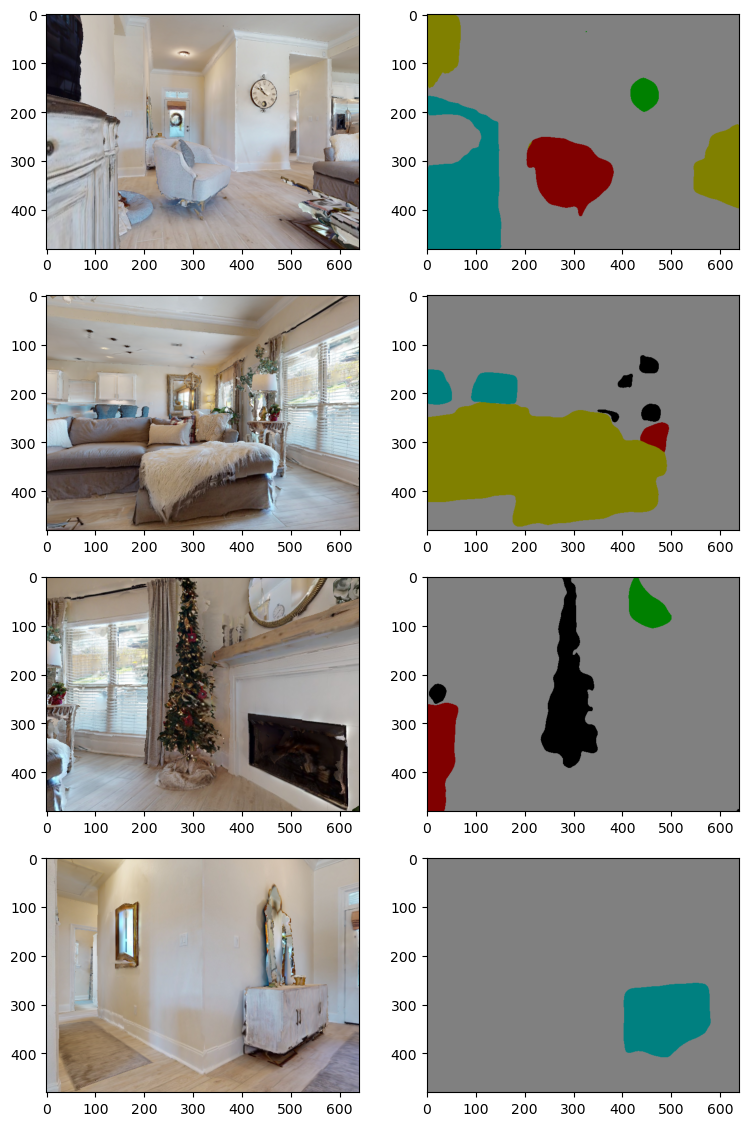

In [23]:
# Visualize predictions

f, axarr = plt.subplots(4, 2, figsize=(9, 14))
axarr[0, 0].imshow(rgb[0].astype(int))
axarr[0, 1].imshow(visualizations[0])
axarr[1, 0].imshow(rgb[1].astype(int))
axarr[1, 1].imshow(visualizations[1])
axarr[2, 0].imshow(rgb[2].astype(int))
axarr[2, 1].imshow(visualizations[2])
axarr[3, 0].imshow(rgb[3].astype(int))
axarr[3, 1].imshow(visualizations[3])

## Map Initialization

In [5]:
from home_robot.agent.mapping.dense.semantic.vision_language_2d_semantic_map_state import VisionLanguage2DSemanticMapState
from home_robot.agent.mapping.dense.semantic.vision_language_2d_semantic_map_module import VisionLanguage2DSemanticMapModule

device = torch.device("cuda:0")
checkpoint_path = (
    Path().resolve().parent.parent.parent / 
    "perception/detection/lseg/checkpoints/demo_e200.ckpt"
)

# State holds global and local map and sensor pose
# See class definition for argument info
semantic_map = VisionLanguage2DSemanticMapState(
    device=device,
    num_environments=1,
    lseg_features_dim=512,
    map_resolution=5,
    map_size_cm=4800,
    global_downscaling=2,
)
semantic_map.init_map_and_pose()

# Module is responsible for updating the local and global maps and poses
# See class definition for argument info
semantic_map_module = VisionLanguage2DSemanticMapModule(
    lseg_checkpoint_path=checkpoint_path,
    lseg_features_dim=512,
    frame_height=480,
    frame_width=640,
    camera_height=0.88,
    hfov=79.0,
    map_size_cm=4800,
    map_resolution=5,
    vision_range=100,
    global_downscaling=2,
    du_scale=4,
    exp_pred_threshold=1.0,
    map_pred_threshold=1.0,
).to(device)

## Map Update

In [6]:
temporal_batch_size = 1

for t in range(0, len(obs), temporal_batch_size):
    # print(f"Update for steps {t} to {t + temporal_batch_size}")
    
    seq_obs = torch.from_numpy(
        obs[t:t + temporal_batch_size, :4, :, :]
    ).unsqueeze(0).to(device)
    seq_pose_delta = torch.from_numpy(
        pose_delta[t:t + temporal_batch_size]
    ).unsqueeze(0).to(device)
    seq_dones = torch.tensor(
        [False] * seq_obs.shape[1]
    ).unsqueeze(0).to(device)
    seq_update_global = torch.tensor(
        [True] * seq_obs.shape[1]
    ).unsqueeze(0).to(device)

    (
        seq_map_features,
        semantic_map.local_map,
        semantic_map.global_map,
        seq_local_pose,
        seq_global_pose,
        seq_lmb,
        seq_origins,
    ) = semantic_map_module(
        seq_obs,
        seq_pose_delta,
        seq_dones,
        seq_update_global,
        semantic_map.local_map,
        semantic_map.global_map,
        semantic_map.local_pose,
        semantic_map.global_pose,
        semantic_map.lmb,
        semantic_map.origins,
    )

    semantic_map.local_pose = seq_local_pose[:, -1]
    semantic_map.global_pose = seq_global_pose[:, -1]
    semantic_map.lmb = seq_lmb[:, -1]
    semantic_map.origins = seq_origins[:, -1]

In [7]:
# Global semantic map of shape 
# (batch_size, num_channels, M, M)
# where num_channels = 4 + 512
# 0: obstacle map
# 1: explored area
# 2: current agent location
# 3: past agent locations
# 4: number of cell updates
# 5, 6, .., 5 + 512: CLIP map cell features
semantic_map.global_map.shape

torch.Size([1, 517, 960, 960])

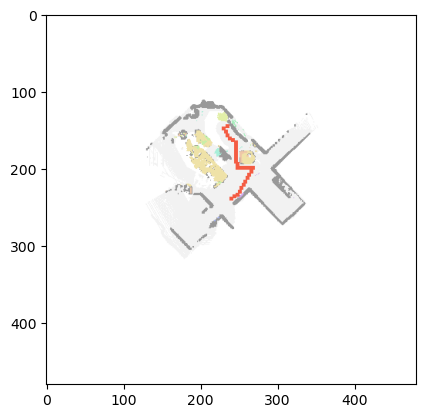

In [9]:
# Local semantic map visualization

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from home_robot.agent.perception.detection.coco_maskrcnn.coco_categories import (
    coco_categories, coco_categories_color_palette,
)

map_color_palette = [
    1.0,
    1.0,
    1.0,  # empty space
    0.6,
    0.6,
    0.6,  # obstacles
    0.95,
    0.95,
    0.95,  # explored area
    0.96,
    0.36,
    0.26,  # visited area
    *coco_categories_color_palette,
]
map_color_palette = [int(x * 255.0) for x in map_color_palette]
num_sem_categories = len(coco_categories)

semantic_categories_map = semantic_map.get_semantic_map(
    0,
    semantic_map_module.lseg,
    labels=list(coco_categories.keys())[:-1] + ["other"]
)

obstacle_map = semantic_map.get_obstacle_map(0)
explored_map = semantic_map.get_explored_map(0)
visited_map = semantic_map.get_visited_map(0)

semantic_categories_map += 4
no_category_mask = semantic_categories_map == 4 + num_sem_categories - 1
obstacle_mask = np.rint(obstacle_map) == 1
explored_mask = np.rint(explored_map) == 1
visited_mask = visited_map == 1
semantic_categories_map[no_category_mask] = 0
semantic_categories_map[np.logical_and(no_category_mask, explored_mask)] = 2
semantic_categories_map[np.logical_and(no_category_mask, obstacle_mask)] = 1
semantic_categories_map[visited_mask] = 3

semantic_map_vis = Image.new("P", semantic_categories_map.shape)
semantic_map_vis.putpalette(map_color_palette)
semantic_map_vis.putdata(semantic_categories_map.flatten().astype(np.uint8))
semantic_map_vis = semantic_map_vis.convert("RGB")
semantic_map_vis = np.flipud(semantic_map_vis)
plt.imshow(semantic_map_vis)